In [ ]:
import os
import shutil
import glob
import numpy as np
import pandas as pd
from scipy.io import loadmat
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import gradio as gr
from PIL import Image
from sklearn.utils import class_weight

print("All libraries imported successfully.")

All libraries imported successfully.


In [ ]:
import os

print("Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

print("\nCopying datasets from Google Drive to Colab local storage...")
print("This will take several minutes but will make processing much faster.")

# Define source paths in your Google Drive
mall_source = '/content/drive/MyDrive/mini_project/dataset/mall_dataset'
shanghaitech_source = '/content/drive/MyDrive/mini_project/dataset/shanghaitech_dataset/ShanghaiTech'
ucf_qnrf_source = '/content/drive/MyDrive/mini_project/dataset/ucf_qnrf_dataset/UCF-QNRF_ECCV18'

# Define destination paths in Colab's local environment
mall_dest = '/content/mall_dataset'
shanghaitech_dest = '/content/shanghaitech_dataset'
ucf_qnrf_dest = '/content/ucf_qnrf_dataset'

# Execute the copy commands
!cp -r "{mall_source}" "{mall_dest}"
!cp -r "{shanghaitech_source}" "{shanghaitech_dest}"
!cp -r "{ucf_qnrf_source}" "{ucf_qnrf_dest}"

print("\nCopying complete! ✅")

Mounting Google Drive...
Mounted at /content/drive

Copying datasets from Google Drive to Colab local storage...
This will take several minutes but will make processing much faster.

Copying complete! ✅


In [ ]:
# --- Part 1: Load and Label the MALL Dataset from LOCAL COPY ---
print("Processing MALL dataset...")
base_dir_mall = '/content/mall_dataset'
mall_frames_dir = os.path.join(base_dir_mall, 'frames')
mat_file_path = os.path.join(base_dir_mall, 'mall_gt.mat')
mat_data = loadmat(mat_file_path)
ground_truth_counts = mat_data['frame'][0]
counts = [item[0][0][0] for item in ground_truth_counts]
image_files = sorted([f for f in os.listdir(mall_frames_dir) if f.endswith('.jpg')])
df_mall = pd.DataFrame({'filepath': [os.path.join(mall_frames_dir, f) for f in image_files], 'count': counts})
def get_scalar_count(value):
    while hasattr(value, '__len__') and not isinstance(value, str): value = value[0] if len(value) > 0 else 0
    return int(value)
df_mall['count'] = df_mall['count'].apply(get_scalar_count)
print(f"Loaded {len(df_mall)} images from the MALL dataset.")

# --- Part 2: Load and Label the ShanghaiTech Dataset from LOCAL COPY ---
print("\nProcessing ShanghaiTech dataset...")
base_dir_shanghai = '/content/shanghaitech_dataset'
shanghai_data = []
parts_to_process = [os.path.join(base_dir_shanghai, 'part_A'), os.path.join(base_dir_shanghai, 'part_B')]
for part_path in parts_to_process:
    for data_split in ['train_data', 'test_data']:
        split_path = os.path.join(part_path, data_split)
        image_dir = os.path.join(split_path, 'images')
        gt_dir = os.path.join(split_path, 'ground-truth')
        image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))
        for img_path in image_paths:
            filename = os.path.basename(img_path).replace('.jpg', '.mat').replace('IMG_', 'GT_IMG_')
            gt_path = os.path.join(gt_dir, filename)
            try:
                mat = loadmat(gt_path)
                count = len(mat['image_info'][0, 0][0, 0][0])
                shanghai_data.append({'filepath': img_path, 'count': count})
            except FileNotFoundError: continue
df_shanghai = pd.DataFrame(shanghai_data)
print(f"Loaded and labeled {len(df_shanghai)} images from the ShanghaiTech dataset.")

# --- Part 3: Load and Label a SUBSET of the UCF-QNRF Dataset from LOCAL COPY ---
print("\nProcessing a subset of the UCF-QNRF dataset...")
base_dir_ucf = '/content/ucf_qnrf_dataset'
IMAGE_LIMIT = 1000
ucf_data = []
image_paths_ucf = glob.glob(os.path.join(base_dir_ucf, 'Train', '*.jpg')) + \
                  glob.glob(os.path.join(base_dir_ucf, 'Test', '*.jpg'))
for img_path in image_paths_ucf:
    if len(ucf_data) >= IMAGE_LIMIT:
        print(f"Reached image limit of {IMAGE_LIMIT}. Stopping.")
        break
    gt_path = img_path.replace('.jpg', '_ann.mat')
    try:
        mat = loadmat(gt_path)
        count = len(mat['annPoints'])
        ucf_data.append({'filepath': img_path, 'count': count})
    except FileNotFoundError: continue
df_ucf = pd.DataFrame(ucf_data)
print(f"Loaded and labeled {len(df_ucf)} images from the UCF-QNRF dataset.")

# --- Part 4: Combine All Three and Use Refined Categories ---
print("\nCombining all datasets...")
def get_final_category(count):
    if count <= 10: return 'Very_Low'
    elif count <= 75: return 'Low'
    elif count <= 400: return 'Medium'
    else: return 'High'
df_mall['category'] = df_mall['count'].apply(get_final_category)
df_shanghai['category'] = df_shanghai['count'].apply(get_final_category)
df_ucf['category'] = df_ucf['count'].apply(get_final_category)
df = pd.concat([
    df_mall[['filepath', 'category']],
    df_shanghai[['filepath', 'category']],
    df_ucf[['filepath', 'category']]
], ignore_index=True)
print(f"\nTotal combined images: {len(df)}")
print("\nFinal category distribution:")
print(df['category'].value_counts())

Processing MALL dataset...
Loaded 2000 images from the MALL dataset.

Processing ShanghaiTech dataset...
Loaded and labeled 1198 images from the ShanghaiTech dataset.

Processing a subset of the UCF-QNRF dataset...
Reached image limit of 1000. Stopping.
Loaded and labeled 1000 images from the UCF-QNRF dataset.

Combining all datasets...

Total combined images: 4198

Final category distribution:
category
Medium      2785
High         794
Low          566
Very_Low      53
Name: count, dtype: int64


In [ ]:
def copy_files(dataframe, dest_dir):
    for index, row in dataframe.iterrows():
        src_path = row['filepath']
        filename = os.path.basename(src_path)
        unique_filename = f"{index}_{filename}"
        dest_path = os.path.join(dest_dir, row['category'], unique_filename)
        os.makedirs(os.path.join(dest_dir, row['category']), exist_ok=True)
        shutil.copyfile(src_path, dest_path)

processed_dir = '/content/processed_images'
train_dir = os.path.join(processed_dir, 'train')
validation_dir = os.path.join(processed_dir, 'validation')

if os.path.exists(processed_dir):
    shutil.rmtree(processed_dir)
os.makedirs(train_dir)
os.makedirs(validation_dir)

df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
split_index = int(len(df_shuffled) * 0.8)
train_df = df_shuffled.iloc[:split_index]
validation_df = df_shuffled.iloc[split_index:]

print("Copying training images... This may take a few minutes.")
copy_files(train_df, train_dir)
print("Copying validation images...")
copy_files(validation_df, validation_dir)
print("\nImages have been successfully organized. ✅")
print(f"Total training images: {len(train_df)}")
print(f"Total validation images: {len(validation_df)}")

Copying training images... This may take a few minutes.
Copying validation images...

Images have been successfully organized. ✅
Total training images: 3358
Total validation images: 840


In [ ]:
base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/tmp/ipython-input-558431783.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,384,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,644,548 (71.12 MB)

 Trainable params: 16,386,564 (62.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')
print("\nClass Indices:", train_generator.class_indices)

Found 3358 images belonging to 4 classes.
Found 840 images belonging to 4 classes.

Class Indices: {'High': 0, 'Low': 1, 'Medium': 2, 'Very_Low': 3}


In [ ]:
class_labels = sorted(train_generator.class_indices.keys())
y_train_labels = train_generator.classes
class_weights_array = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights = dict(enumerate(class_weights_array))
print(f"Class Labels: {class_labels}")
print(f"Calculated Class Weights: {class_weights}")

epochs = 15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights,
    verbose=1)

model.save('final_crowd_model.h5')
print("\nFinal model saved as final_crowd_model.h5")

Class Labels: ['High', 'Low', 'Medium', 'Very_Low']
Calculated Class Weights: {0: np.float64(1.3015503875968992), 1: np.float64(1.8697104677060135), 2: np.float64(0.3783235691753042), 3: np.float64(18.655555555555555)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.4388 - loss: 27.1049 - val_accuracy: 0.4655 - val_loss: 1.4430
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.3842 - loss: 1.4296 - val_accuracy: 0.5631 - val_loss: 1.0923
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.3220 - loss: 1.0171 - val_accuracy: 0.5429 - val_loss: 0.9951
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.3253 - loss: 0.9933 - val_accuracy: 0.3440 - val_loss: 1.1574
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.3394 - loss: 0.9311 - val_accuracy: 0.5940 - val_loss: 0.9006
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.3071 - loss: 0.9126 - val_accuracy: 0.3310 - val_loss: 1.0327
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.3386 - loss: 0.8429 - val_accuracy: 0.3369 - val_loss: 1.1122
Epoch 8/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.3506 - loss: 1.0006 - val_acc


Final model saved as final_crowd_model.h5


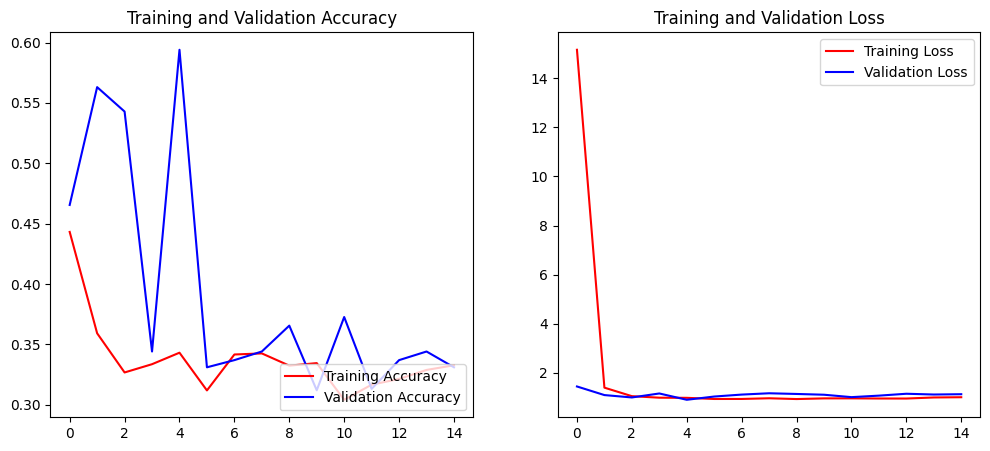

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'r', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'r', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
import os
from google.colab import files

# Create a folder for the example images
os.makedirs("examples", exist_ok=True)

print("Please upload your four renamed example images (very_low_example.jpg, etc.):")

# Upload the files into the session
# When the 'Choose Files' button appears, select all four of your images
uploaded = files.upload()

# Move the uploaded files into the 'examples' folder
for filename in uploaded.keys():
    !mv "{filename}" "examples/"

print("\nExample images uploaded successfully! ✅")

Please upload your four renamed example images (very_low_example.jpg, etc.):


Saving high_example.jpg to high_example.jpg
Saving low_example.jpg to low_example.jpg
Saving medium_example.jpg to medium_example.jpg
Saving very_low_example.jpg to very_low_example.jpg

Example images uploaded successfully! ✅


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# Load your final, trained model
model = tf.keras.models.load_model('final_crowd_model.h5')

# Define the class labels your model was trained on
class_labels = ['High', 'Low', 'Medium', 'Very_Low']

# Create the prediction function
def predict_crowd_density(input_image):
    if input_image is None:
        return "Please upload an image."
    img = input_image.resize((150, 150))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    prediction = model.predict(img_array, verbose=0)[0]
    confidences = {label: float(score) for label, score in zip(class_labels, prediction)}
    return confidences

# --- Define the list of example images ---
example_paths = [
    ["examples/very_low_example.jpg"],
    ["examples/low_example.jpg"],
    ["examples/medium_example.jpg"],
    ["examples/high_example.jpg"]
]

# Create and launch the Gradio Interface
iface = gr.Interface(
    fn=predict_crowd_density,
    inputs=gr.Image(type="pil", label="Upload a Crowd Image"),
    outputs=gr.Label(num_top_classes=4, label="Prediction Result"),
    title="Crowd Monitoring and Alert System (Final Model)",
    description="This model was trained with refined categories. Click an example below to test.",
    examples=example_paths
)

# Launch the app with a public, shareable link
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://594580cbb85511ee96.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
